# Lab 3: Contextual Bandit-Based News Article Recommendation

**`Course`:** Reinforcement Learning Fundamentals  
**`Student Name`:**  
**`Roll Number`:**  
**`GitHub Branch`:** firstname_U20230xxx  

# Imports and Setup

In [9]:
# ============================================================
# Lab 3: Contextual Bandit-Based News Article Recommendation
# Full solution (single-notebook)
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression

from rlcmab_sampler import sampler


# Load Datasets

In [10]:
# -----------------------------
# 0) CONFIG (SET THIS)
# -----------------------------
ROLL_NUMBER = 128 
T = 10_000
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)


# -----------------------------
# 1) LOAD DATASETS
# -----------------------------
news_df = pd.read_csv("data/news_articles.csv")
train_users = pd.read_csv("data/train_users.csv")
test_users = pd.read_csv("data/test_users.csv")

print("\n=== NEWS DATASET COLUMNS ===")
print(list(news_df.columns))

print("\n=== TRAIN USERS DATASET COLUMNS ===")
print(list(train_users.columns))

print("\n=== TEST USERS DATASET COLUMNS ===")
print(list(test_users.columns))

print("\n=== Head(news_df) ===")
display(news_df.head())

print("\n=== Head(train_users) ===")
display(train_users.head())

print("\n=== Missing values (train_users) ===")
display(train_users.isna().sum().sort_values(ascending=False).head(15))


=== NEWS DATASET COLUMNS ===
['link', 'headline', 'category', 'short_description', 'authors', 'date']

=== TRAIN USERS DATASET COLUMNS ===
['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'browser_version', 'background_app_count', 'session_inactivity_duration', 'network_jitter', 'region_code', 'subscriber', 'label']

=== TEST USERS DATASET COLUMNS ===
['user_id', 'age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 

,link,headline,category,short_description,authors,date
0,https://www.huffpost.com/entry/covid-boosters-...,Over 4 Million Americans Roll Up Sleeves For O...,U.S. NEWS,Health experts said it is too early to predict...,"Carla K. Johnson, AP",2022-09-23
1,https://www.huffpost.com/entry/american-airlin...,"American Airlines Flyer Charged, Banned For Li...",U.S. NEWS,He was subdued by passengers and crew when he ...,Mary Papenfuss,2022-09-23
2,https://www.huffpost.com/entry/funniest-tweets...,23 Of The Funniest Tweets About Cats And Dogs ...,COMEDY,"""Until you have a dog you don't understand wha...",Elyse Wanshel,2022-09-23
3,https://www.huffpost.com/entry/funniest-parent...,The Funniest Tweets From Parents This Week (Se...,PARENTING,"""Accidentally put grown-up toothpaste on my to...",Caroline Bologna,2022-09-23
4,https://www.huffpost.com/entry/amy-cooper-lose...,Woman Who Called Cops On Black Bird-Watcher Lo...,U.S. NEWS,Amy Cooper accused investment firm Franklin Te...,Nina Golgowski,2022-09-22



=== Head(train_users) ===


,user_id,age,income,clicks,purchase_amount,session_duration,content_variety,engagement_score,num_transactions,avg_monthly_spend,...,screen_brightness,battery_percentage,cart_abandonment_count,browser_version,background_app_count,session_inactivity_duration,network_jitter,region_code,subscriber,label
0,U7392,NaN,23053,10,500.00,17.34,0.36661,37.29781,3,187.44,...,4.0,2.0,8,3.17.97,10,22.75,8.0,Z999,False,user_3
1,U2702,56.0,20239,11,913.33,22.22,0.61370,59.36342,5,145.15,...,4.5,63.0,5,1.57.10,8,1.75,4.0,U428,True,user_2
2,U2461,NaN,13907,9,1252.62,41.57,0.80368,76.78706,7,282.03,...,1.3,22.0,2,2.16.94,12,29.33,18.0,Z999,True,user_3
3,U7475,NaN,26615,12,500.00,30.17,0.26499,30.19441,10,195.35,...,4.2,77.0,9,9.90.20,4,21.61,22.0,X123,False,user_3
4,U6040,32.0,27958,13,500.00,65.27,0.36385,37.12153,5,439.68,...,4.6,30.0,9,1.99.38,7,7.58,52.0,S043,False,user_1



=== Missing values (train_users) ===


age                            698
battery_percentage               0
wishlist_size                    0
product_views                    0
repeat_purchase_gap (days)       0
churn_risk_score                 0
loyalty_index                    0
screen_brightness                0
user_id                          0
discount_usage_rate              0
browser_version                  0
background_app_count             0
session_inactivity_duration      0
network_jitter                   0
region_code                      0
dtype: int64

## Data Preprocessing

In this section:
- Handle missing values
- Encode categorical features
- Prepare data for user classification

In [11]:
# -----------------------------
# 2) PREP: USER LABEL MAPPING
# -----------------------------
# PDF says contexts are User1/User2/User3; dataset uses user_1/user_2/user_3
label_map = {"user_1": "User1", "user_2": "User2", "user_3": "User3"}
inv_label_map = {v: k for k, v in label_map.items()}

train_users = train_users.copy()
train_users["label"] = train_users["label"].map(label_map)

# Safety check
assert set(train_users["label"].dropna().unique()).issubset({"User1", "User2", "User3"}), \
    "Unexpected labels in train_users.csv"


## User Classification

Train a classifier to predict the user category (`User1`, `User2`, `User3`),
which serves as the **context** for the contextual bandit.


In [13]:
# Features + target
X = train_users.drop(columns=["label"]).copy()
y = train_users["label"].copy()

# Drop ID-like columns explicitly (very common source of this exact error)
for col in ["user_id", "id", "uid"]:
    if col in X.columns:
        X = X.drop(columns=[col])

# Robustly detect numeric columns:
# Try coercing each column to numeric; if most values become numbers, treat as numeric.
numeric_cols = []
categorical_cols = []

for c in X.columns:
    s = X[c]
    if pd.api.types.is_numeric_dtype(s):
        numeric_cols.append(c)
    else:
        # try to coerce (handles numeric stored as strings)
        coerced = pd.to_numeric(s, errors="coerce")
        numeric_ratio = coerced.notna().mean()
        if numeric_ratio > 0.90:   # threshold; tweak if needed
            X[c] = coerced
            numeric_cols.append(c)
        else:
            categorical_cols.append(c)

print("\nNumeric columns:", numeric_cols)
print("Categorical columns:", categorical_cols)

numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore")),
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_cols),
        ("cat", categorical_transformer, categorical_cols),
    ],
    remainder="drop"
)

clf = Pipeline(steps=[
    ("preprocess", preprocessor),
    ("model", LogisticRegression(max_iter=2000))
])

X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=RANDOM_SEED, stratify=y
)

clf.fit(X_train, y_train)
y_pred_val = clf.predict(X_val)

print("\n=== Classification Accuracy (Validation) ===")
print(accuracy_score(y_val, y_pred_val))
print("\n=== Classification Report (Validation) ===")
print(classification_report(y_val, y_pred_val))


Numeric columns: ['age', 'income', 'clicks', 'purchase_amount', 'session_duration', 'content_variety', 'engagement_score', 'num_transactions', 'avg_monthly_spend', 'avg_cart_value', 'browsing_depth', 'revisit_rate', 'scroll_activity', 'time_on_site', 'interaction_count', 'preferred_price_range', 'discount_usage_rate', 'wishlist_size', 'product_views', 'repeat_purchase_gap (days)', 'churn_risk_score', 'loyalty_index', 'screen_brightness', 'battery_percentage', 'cart_abandonment_count', 'background_app_count', 'session_inactivity_duration', 'network_jitter', 'subscriber']
Categorical columns: ['browser_version', 'region_code']

=== Classification Accuracy (Validation) ===
0.73

=== Classification Report (Validation) ===
              precision    recall  f1-score   support

       User1       0.74      0.84      0.79       142
       User2       0.77      0.85      0.81       142
       User3       0.63      0.46      0.53       116

    accuracy                           0.73       400

/Users/kavishkumar/.pyenv/versions/3.12.2/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:406: ConvergenceWarning: lbfgs failed to converge after 2000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=2000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


# `Contextual Bandit`

## Reward Sampler Initialization

The sampler is initialized using the student's roll number `i`.
Rewards are obtained using `sampler.sample(j)`.


In [14]:
reward_sampler = sampler(ROLL_NUMBER)

## Arm Mapping

| Arm Index (j) | News Category | User Context |
|--------------|---------------|--------------|
| 0–3          | Entertainment, Education, Tech, Crime | User1 |
| 4–7          | Entertainment, Education, Tech, Crime | User2 |
| 8–11         | Entertainment, Education, Tech, Crime | User3 |

In [15]:
# -----------------------------
# 4) ARM MAPPING (MUST MATCH PDF)
# -----------------------------
# Arm order within each context:
# [Entertainment, Education, Tech, Crime]
ARM_CATEGORIES = ["ENTERTAINMENT", "EDUCATION", "TECH", "CRIME"]
CONTEXTS = ["User1", "User2", "User3"]
CONTEXT_OFFSET = {"User1": 0, "User2": 4, "User3": 8}

def arm_index(context: str, arm_k: int) -> int:
    """arm_k in {0,1,2,3} -> global j in {0..11} following the pdf mapping."""
    return CONTEXT_OFFSET[context] + arm_k

## Epsilon-Greedy Strategy

This section implements the epsilon-greedy contextual bandit algorithm.


In [16]:
def simulate_epsilon_greedy(context: str, eps: float, T: int):
    Q = np.zeros(4, dtype=float)
    N = np.zeros(4, dtype=int)
    rewards = np.zeros(T, dtype=float)
    avg_rewards = np.zeros(T, dtype=float)

    for t in range(T):
        # choose action
        if np.random.rand() < eps:
            a = np.random.randint(4)
        else:
            a = int(np.argmax(Q))

        j = arm_index(context, a)
        r = reward_sampler.sample(j)

        # update
        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        rewards[t] = r
        avg_rewards[t] = rewards[:t+1].mean()

    return {"Q": Q, "N": N, "rewards": rewards, "avg": avg_rewards}

## Upper Confidence Bound (UCB)

This section implements the UCB strategy for contextual bandits.

In [17]:
def simulate_ucb(context: str, C: float, T: int):
    Q = np.zeros(4, dtype=float)
    N = np.zeros(4, dtype=int)
    rewards = np.zeros(T, dtype=float)
    avg_rewards = np.zeros(T, dtype=float)

    for t in range(T):
        # pick any untried arm first
        if (N == 0).any():
            a = int(np.where(N == 0)[0][0])
        else:
            bonus = C * np.sqrt(np.log(t + 1) / N)
            a = int(np.argmax(Q + bonus))

        j = arm_index(context, a)
        r = reward_sampler.sample(j)

        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        rewards[t] = r
        avg_rewards[t] = rewards[:t+1].mean()

    return {"Q": Q, "N": N, "rewards": rewards, "avg": avg_rewards}

## SoftMax Strategy

This section implements the SoftMax strategy with temperature $ \tau = 1$.


In [18]:
def simulate_softmax(context: str, tau: float, T: int):
    Q = np.zeros(4, dtype=float)
    N = np.zeros(4, dtype=int)
    rewards = np.zeros(T, dtype=float)
    avg_rewards = np.zeros(T, dtype=float)

    for t in range(T):
        # stable softmax
        z = Q / max(tau, 1e-8)
        z = z - np.max(z)
        p = np.exp(z)
        p = p / p.sum()

        a = int(np.random.choice(4, p=p))
        j = arm_index(context, a)
        r = reward_sampler.sample(j)

        N[a] += 1
        Q[a] += (r - Q[a]) / N[a]

        rewards[t] = r
        avg_rewards[t] = rewards[:t+1].mean()

    return {"Q": Q, "N": N, "rewards": rewards, "avg": avg_rewards}

## Reinforcement Learning Simulation

We simulate the bandit algorithms for $T = 10,000$ steps and record rewards.

P.S.: Change $T$ value as and if required.


In [19]:
# 7) HYPERPARAMETER SWEEPS + PLOTS
# -----------------------------
eps_list = [0.01, 0.05, 0.1]          # at least 3 values
C_list   = [0.5, 1.0, 2.0]            # at least 3 values
tau = 1.0                             # fixed per pdf

results = {
    "eps_greedy": {ctx: {} for ctx in CONTEXTS},
    "ucb":        {ctx: {} for ctx in CONTEXTS},
    "softmax":    {ctx: {} for ctx in CONTEXTS},
}

# Epsilon-Greedy
for ctx in CONTEXTS:
    for eps in eps_list:
        results["eps_greedy"][ctx][eps] = simulate_epsilon_greedy(ctx, eps, T)

# UCB
for ctx in CONTEXTS:
    for C in C_list:
        results["ucb"][ctx][C] = simulate_ucb(ctx, C, T)

# Softmax
for ctx in CONTEXTS:
    results["softmax"][ctx][tau] = simulate_softmax(ctx, tau, T)

## Results and Analysis

This section presents:
- Average Reward vs Time
- Hyperparameter comparisons
- Observations and discussion


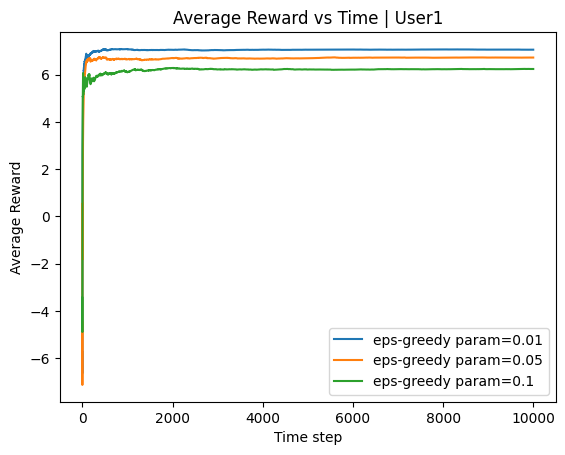

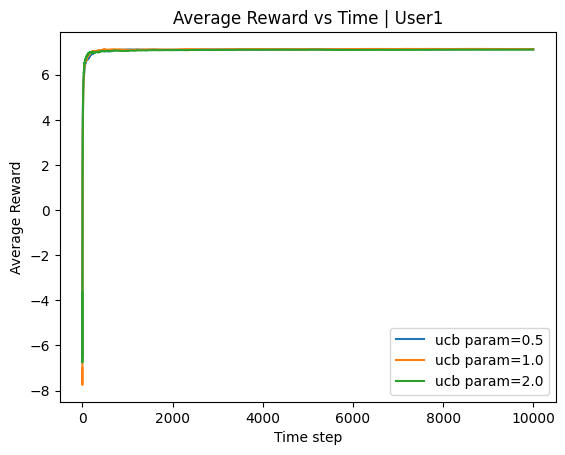

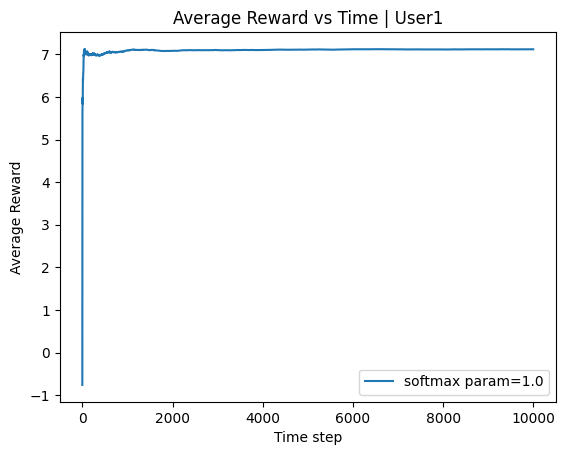

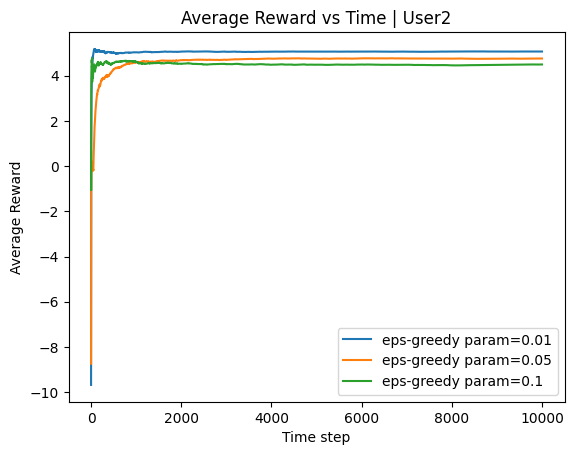

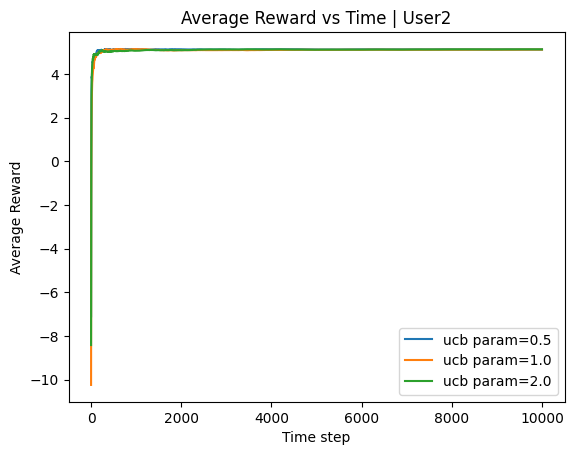

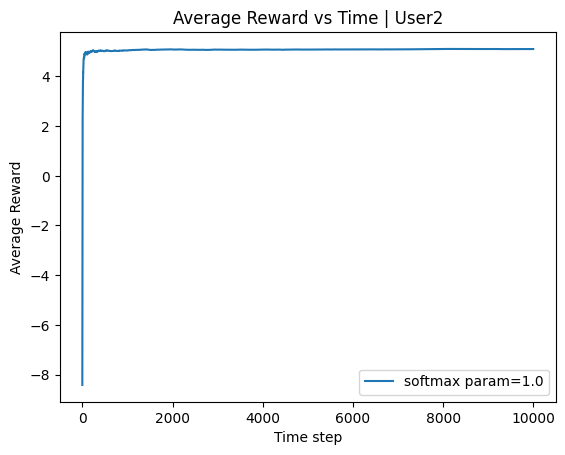

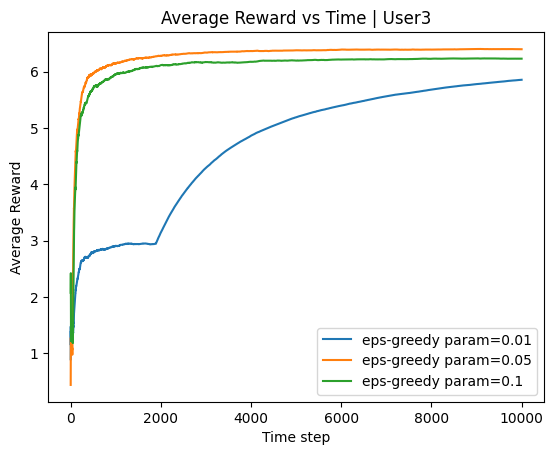

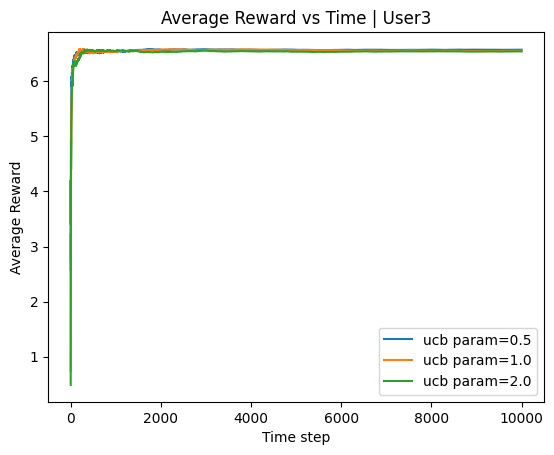

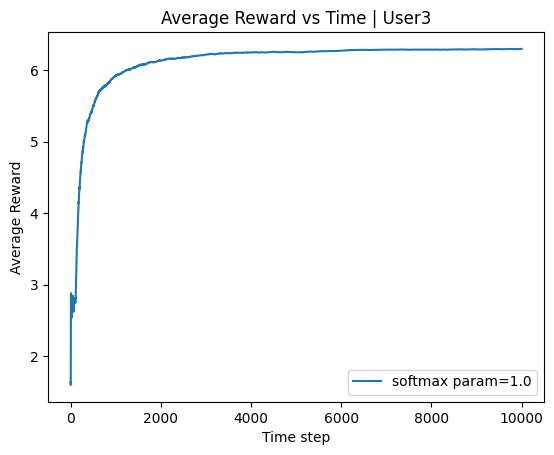


=== User1: Epsilon-Greedy final average rewards ===


,epsilon,final_avg_reward
0,0.01,7.051533
1,0.05,6.718959
2,0.10,6.234837



=== User1: UCB final average rewards ===


,C,final_avg_reward
1,1.0,7.136230
0,0.5,7.129086
2,2.0,7.116227



=== User1: Softmax final average rewards ===


,tau,final_avg_reward
0,1.0,7.118841



=== User2: Epsilon-Greedy final average rewards ===


,epsilon,final_avg_reward
0,0.01,5.068395
1,0.05,4.759875
2,0.10,4.496071



=== User2: UCB final average rewards ===


,C,final_avg_reward
2,2.0,5.131894
0,0.5,5.128481
1,1.0,5.121148



=== User2: Softmax final average rewards ===


,tau,final_avg_reward
0,1.0,5.102821



=== User3: Epsilon-Greedy final average rewards ===


,epsilon,final_avg_reward
1,0.05,6.399093
2,0.10,6.231233
0,0.01,5.856584



=== User3: UCB final average rewards ===


,C,final_avg_reward
0,0.5,6.572470
1,1.0,6.554321
2,2.0,6.541084



=== User3: Softmax final average rewards ===


,tau,final_avg_reward
0,1.0,6.300301



Best eps per context: {'User1': 0.01, 'User2': 0.01, 'User3': 0.05}
Best C per context: {'User1': 1.0, 'User2': 2.0, 'User3': 0.5}


In [20]:
def plot_avg_reward_vs_time(strategy_name: str, ctx: str, param_dict: dict, title_prefix: str):
    plt.figure()
    for param, out in param_dict.items():
        plt.plot(out["avg"], label=f"{strategy_name} param={param}")
    plt.xlabel("Time step")
    plt.ylabel("Average Reward")
    plt.title(f"{title_prefix} | {ctx}")
    plt.legend()
    plt.show()


# Plot Average Reward vs Time (per context) for all strategies
for ctx in CONTEXTS:
    plot_avg_reward_vs_time("eps-greedy", ctx, results["eps_greedy"][ctx], "Average Reward vs Time")
    plot_avg_reward_vs_time("ucb",        ctx, results["ucb"][ctx],        "Average Reward vs Time")
    plot_avg_reward_vs_time("softmax",    ctx, results["softmax"][ctx],    "Average Reward vs Time")


# Hyperparameter comparison plots (final avg reward at T)
def final_avg_table(strategy_block: dict, ctx: str, param_name: str):
    rows = []
    for param, out in strategy_block[ctx].items():
        rows.append({param_name: param, "final_avg_reward": float(out["avg"][-1])})
    return pd.DataFrame(rows).sort_values("final_avg_reward", ascending=False)

for ctx in CONTEXTS:
    print(f"\n=== {ctx}: Epsilon-Greedy final average rewards ===")
    display(final_avg_table(results["eps_greedy"], ctx, "epsilon"))

    print(f"\n=== {ctx}: UCB final average rewards ===")
    display(final_avg_table(results["ucb"], ctx, "C"))

    print(f"\n=== {ctx}: Softmax final average rewards ===")
    display(final_avg_table(results["softmax"], ctx, "tau"))


# Pick best hyperparams by final avg reward (per context) for eps-greedy and ucb
best_eps = {}
best_C = {}

for ctx in CONTEXTS:
    eps_df = final_avg_table(results["eps_greedy"], ctx, "epsilon")
    best_eps[ctx] = float(eps_df.iloc[0]["epsilon"])

    c_df = final_avg_table(results["ucb"], ctx, "C")
    best_C[ctx] = float(c_df.iloc[0]["C"])

print("\nBest eps per context:", best_eps)
print("Best C per context:", best_C)

In [ ]:
# 8) TRAIN FINAL POLICIES (choose one strategy to deploy)
# -----------------------------
# deploy the best-performing strategy overall.
# Here: deploy UCB with best_C per context (often strong in practice).

final_policy = {}
for ctx in CONTEXTS:
    final_policy[ctx] = simulate_ucb(ctx, best_C[ctx], T)

print("\n=== Final learned Q-values (UCB policy) ===")
for ctx in CONTEXTS:
    print(ctx, final_policy[ctx]["Q"])


=== Final learned Q-values (UCB policy) ===
User1 [-6.33029626 -6.07516226  7.11160707 -1.80087939]
User2 [-10.95588542   0.41842602   5.15179263  -1.19694164]
User3 [-0.14948962  6.56017473  3.33322517  2.7095898 ]


In [22]:
# -----------------------------
# 9) RECOMMENDATION ENGINE (test_users.csv -> category + sampled article)
# -----------------------------
# Step 1: classify user context using classifier
test_users_features = test_users.copy()
pred_contexts = clf.predict(test_users_features)

# Step 2: select best news category (arm) using learned bandit Q for that context
def choose_best_category_for_context(ctx: str) -> str:
    Q = final_policy[ctx]["Q"]
    arm_k = int(np.argmax(Q))
    return ARM_CATEGORIES[arm_k]

# Step 3: sample an article from that category
# Note: news_df has many categories, but we only sample from the 4 required ones.
def sample_article_from_category(cat: str, news_df: pd.DataFrame) -> dict:
    pool = news_df[news_df["category"].astype(str).str.upper() == cat.upper()]
    if len(pool) == 0:
        # fallback: if category not present (shouldn't happen here)
        pool = news_df.sample(1, random_state=np.random.randint(1_000_000))
    row = pool.sample(1, random_state=np.random.randint(1_000_000)).iloc[0]
    return {
        "headline": row.get("headline", ""),
        "link": row.get("link", ""),
        "short_description": row.get("short_description", ""),
        "authors": row.get("authors", ""),
        "date": row.get("date", ""),
        "article_category": row.get("category", "")
    }

recommendations = []
for idx, user_row in test_users.iterrows():
    user_id = user_row.get("user_id", f"row_{idx}")
    ctx = pred_contexts[idx]
    chosen_cat = choose_best_category_for_context(ctx)
    article = sample_article_from_category(chosen_cat, news_df)

    recommendations.append({
        "user_id": user_id,
        "predicted_context": ctx,
        "recommended_news_category": chosen_cat,
        "headline": article["headline"],
        "link": article["link"],
        "date": article["date"],
        "authors": article["authors"],
        "short_description": article["short_description"]
    })

rec_df = pd.DataFrame(recommendations)
print("\n=== Sample recommendations (first 10) ===")
display(rec_df.head(10))

# Optional: save outputs for inspection
rec_df.to_csv(f"lab3_recommendations_{ROLL_NUMBER}.csv", index=False)
print(f"\nSaved: lab3_recommendations_{ROLL_NUMBER}.csv")


=== Sample recommendations (first 10) ===


,user_id,predicted_context,recommended_news_category,headline,link,date,authors,short_description
0,U4058,User2,TECH,'HBO Now' Wriggles Free From Apple's Grasp,https://www.huffingtonpost.com/entry/hbo-now-w...,2015-07-16,Damon Beres,"No iPhone, no problem."
1,U1118,User1,TECH,All It Takes To Buy A Stolen Password On The I...,https://www.huffingtonpost.com/entry/stolen-cr...,2015-10-15,Ryan Grenoble,"Entire digital identities can be bought by ""an..."
2,U6555,User1,TECH,These Phone Notifications Could Actually Chang...,https://www.huffingtonpost.com/entry/ready4k-l...,2015-07-16,Damon Beres and Rebecca Klein,Here's one genuinely brilliant use for text me...
3,U9170,User1,TECH,Jeff Bezos Rescued By Ecuadorian Navy,https://www.huffingtonpost.com/entry/jeff-bezo...,2014-01-04,"Reuters, Reuters",Galapagos National Park draws many wealthy and...
4,U3348,User1,TECH,"At Mardi Gras, Dance Like The FBI’s Watching",https://www.huffingtonpost.com/entry/mardi-gra...,2016-01-20,Casey Williams,Because -- surprise! -- they will be.
5,U2244,User3,EDUCATION,Teaching the Bible as Literature in Public Hig...,https://www.huffingtonpost.com/entry/teaching-...,2014-12-27,"Frank Breslin, ContributorRetired high-school ...",Aphorisms are an excellent way of encouraging ...
6,U3022,User3,EDUCATION,Making the Humanities Relevant,https://www.huffingtonpost.com/entry/making-th...,2014-09-17,"Frank Breslin, ContributorRetired high-school ...",A school's first priority should be to teach s...
7,U5291,User1,TECH,Tim Berners-Lee Honored At London 2012 Olympic...,https://www.huffingtonpost.com/entry/tim-berne...,2012-07-28,Dino Grandoni,What was the joke? Well you couldn't read Goog...
8,U1945,User3,EDUCATION,Mr. MacPherson Circa 1982,https://www.huffingtonpost.com/entry/mr-macphe...,2015-05-05,"Renate Cunneen, ContributorAlways pondering ev...",Teachers are important and have the extreme ab...
9,U6084,User2,TECH,"Apple Doubles Women, Minority Hires But Remain...",https://www.huffingtonpost.com/entry/apple-dou...,2015-08-14,"Brandon Bailey, AP","Things are improving, but there's still work t..."



Saved: lab3_recommendations_128.csv


In [23]:
# For each context: show Q estimates per category after training
def Q_table(policy_dict: dict):
    rows = []
    for ctx in CONTEXTS:
        Q = policy_dict[ctx]["Q"]
        for k, cat in enumerate(ARM_CATEGORIES):
            rows.append({"context": ctx, "category": cat, "Q_estimate": float(Q[k])})
    return pd.DataFrame(rows)

print("\n=== Expected Reward Distribution (Estimated Q) for final policy ===")
display(Q_table(final_policy).sort_values(["context", "Q_estimate"], ascending=[True, False]))


=== Expected Reward Distribution (Estimated Q) for final policy ===


,context,category,Q_estimate
2,User1,TECH,7.111607
3,User1,CRIME,-1.800879
1,User1,EDUCATION,-6.075162
0,User1,ENTERTAINMENT,-6.330296
6,User2,TECH,5.151793
5,User2,EDUCATION,0.418426
7,User2,CRIME,-1.196942
4,User2,ENTERTAINMENT,-10.955885
9,User3,EDUCATION,6.560175
10,User3,TECH,3.333225


## Final Observations

- Comparison of Epsilon-Greedy, UCB, and SoftMax
- Effect of hyperparameters
- Strengths and limitations of each approach
